<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Papers/blob/main/Violence_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
from IPython.display import clear_output 

#Datasets

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset
!unzip \*.zip && rm *.zip
clear_output()

In [3]:
!git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos.git

Cloning into 'A-Dataset-for-Automatic-Violence-Detection-in-Videos'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 376 (delta 3), reused 11 (delta 3), pack-reused 364
Receiving objects: 100% (376/376), 1.02 GiB | 35.03 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (355/355), done.


In [4]:
os.makedirs('/content/NonViolence/', exist_ok=True)
os.makedirs('/content/Violence/', exist_ok=True)

nv = '/content/Real Life Violence Dataset/NonViolence/'
v = '/content/Real Life Violence Dataset/Violence/'

for V in [v, nv]:
  for i in os.listdir(V):
    R = V+i
    os.replace(R, R.replace('Real Life Violence Dataset/', ''))

In [5]:
path = '/content/A-Dataset-for-Automatic-Violence-Detection-in-Videos/violence-detection-dataset/'
choices = ['/content/NonViolence/', '/content/NonViolence/', '/content/Violence/', '/content/Violence/']

for id, V in enumerate(['non-violent/cam1/', 'non-violent/cam2/', 'violent/cam1/', 'violent/cam2/']):
  for i in os.listdir(path+V):
    os.replace(path+V+i, choices[id]+i)

In [6]:
os.makedirs('/content/data/', exist_ok=True)
os.replace('/content/NonViolence/', '/content/data/NonViolence/')
os.replace('/content/Violence/', '/content/data/Violence/')

#2

In [ ]:
!pip uninstall emoji
!pip install emoji==1.7.0
!pip install text2emotion

import text2emotion as te

clear_output()

In [ ]:
sample = "I was asked to sign a third party contract a week out from stay"
te.get_emotion(sample)

{'Happy': 0.0, 'Angry': 0.25, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 0.75}

https://www.kaggle.com/datasets/adiamaan/movie-subtitle-dataset/code

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d adiamaan/movie-subtitle-dataset
!unzip \*.zip && rm *.zip
clear_output()

In [ ]:
import pandas as pd
sub = pd.read_csv('/content/movies_subtitles.csv')
meta = pd.read_csv('/content/movies_meta.csv')

In [ ]:

abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abb(x):
    if type(x) != str:
      return str(x)
    word_list = x.split()
    r_string = []
    for word in word_list:
        r_string.append(abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word)
    return ' '.join(r_string)


In [ ]:
sub['text'] = sub.text.apply(convert_abb)

# # Remove emojis
# train_df['clean_text'] = train_df.clean_text.apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
# test_df['clean_text'] = test_df.clean_text.apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

In [ ]:
# sub['text'] = sub.text.apply(convert_abb)

ss = sub.text.apply(lambda x: te.get_emotion(x))

In [ ]:
import json
with open('/content/drive/MyDrive/forage/data.json', 'w', encoding='utf-8') as f:
    json.dump(ss, f, ensure_ascii=False, indent=4)

In [ ]:
ll

In [ ]:
import json
with open('/content/drive/MyDrive/forage/data.json', 'w', encoding='utf-8') as f:
    json.dump(ss, f, ensure_ascii=False, indent=4)

#Faces Extract

In [7]:
#import shutil
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
!mkdir frame
!mkdir faces

In [11]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d erikvdven/tiktok-trending-december-2020
!unzip \*.zip && rm *.zip
clear_output()

In [9]:
paths=[]
for dirname, _, filenames in os.walk('/content/tiktok-trending-december-2020/videos'):
    for filename in filenames:
        paths+=[(os.path.join(dirname, filename))]
paths=sorted(paths)

d_frame='/content/frame/'
d_faces='/content/faces/'

In [13]:
def video_2_frames(video_file, image_dir=d_frame, image_file='img_%s.png'):
    i = 0
    cap = cv2.VideoCapture(video_file)
    while(cap.isOpened()):
        flag, frame = cap.read()
        if flag == False:
            break
        cv2.imwrite(image_dir+image_file % str(i).zfill(6), frame) 
        i += 1
    cap.release()

In [15]:
video_2_frames('/content/videos/6875317312082201857.mp4')

frame_paths=[]
for file in os.listdir(d_frame):
    frame_paths+=[os.path.join(d_frame,file)]
frame_paths=sorted(frame_paths)
print(frame_paths[0:5])

['/content/frame/img_000000.png', '/content/frame/img_000001.png', '/content/frame/img_000002.png', '/content/frame/img_000003.png', '/content/frame/img_000004.png']


In [21]:
!wget https://raw.githubusercontent.com/kipr/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

path_cas='/kaggle/inpu/content/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(path_cas)

In [25]:
for i,path in enumerate(random.sample(frame_paths,10)):   
    img = cv2.imread(path)
    print()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    print(faces)
    lenf=len(faces)
    if lenf>0:
        print(lenf)
        f, ax = plt.subplots(1,1+lenf, figsize=(2*(1+lenf),2))
        ax[0].imshow(img, aspect='auto') 
        ax[0].set_xticks([]) 
        ax[0].set_yticks([])            
        for j,(x,y,w,h) in enumerate(faces):
            #print(x,y,w,h)
            face = img[y:y+h, x:x+w]
            face_file = str(i).zfill(4)+'_'+str(j).zfill(2)+'.png'
            face_path = os.path.join(d_faces,face_file)
            ax[j+1].imshow(face, aspect='auto')
            ax[j+1].set_xticks([]) 
            ax[j+1].set_yticks([])
            cv2.imwrite(face_path, cv2.cvtColor(face, cv2.COLOR_BGR2RGB))                
        plt.show()

error: ignored

In [22]:
# for i,path in enumerate(random.sample(frame_paths,10)):   
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     try:
#         faces = face_cascade.detectMultiScale(gray, 1.3, 5)
#         print(faces)
#         lenf=len(faces)
#         if lenf>0:
#             print(lenf)
#             f, ax = plt.subplots(1,1+lenf, figsize=(2*(1+lenf),2))
#             ax[0].imshow(img, aspect='auto') 
#             ax[0].set_xticks([]) 
#             ax[0].set_yticks([])            
#             for j,(x,y,w,h) in enumerate(faces):
#                 #print(x,y,w,h)
#                 face = img[y:y+h, x:x+w]
#                 face_file = str(i).zfill(4)+'_'+str(j).zfill(2)+'.png'
#                 face_path = os.path.join(d_faces,face_file)
#                 ax[j+1].imshow(face, aspect='auto')
#                 ax[j+1].set_xticks([]) 
#                 ax[j+1].set_yticks([])
#                 cv2.imwrite(face_path, cv2.cvtColor(face, cv2.COLOR_BGR2RGB))                
#             plt.show()
#     except:
#         print('except')
#         continue

except
except
except
except
except
except
except
except
except
except


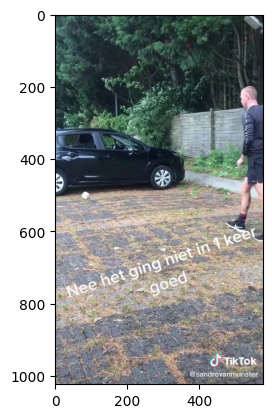

In [36]:
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
#     -O haarcascade_frontalface_default.xml
# !wget --no-check-certificate \
#     https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/utils/common.py \
#     -O common.py

# these imports let you use opencv
import cv2 #opencv itself
import common #some useful opencv functions
import numpy as np # matrix manipulations



  # this is a pre-trained face cascade
for img_path in frame_paths:
  test_image = cv2.imread(img_path)
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(test_image, 1.3, 5)
  for (x,y,w,h) in faces:
      cv2.rectangle(test_image,(x,y),(x+w,y+h),(255,0,0),2)
  plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

In [33]:
import cv2

# Face Detection
face_cascade = cv2.CascadeClassifier("/content/haarcascade_frontalface_alt.xml")

for frame_path in frame_paths:
    frame = cv2.imread(frame_path)
    if frame is not None:
      gray_frame=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      # print(gray_frame)
      faces = face_cascade.detectMultiScale(frame,1.3,5)
      print(faces)
      for (x,y,w,h) in faces:
          cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
          cv2.rectangle(gray_frame,(x,y),(x+w,y+h),(0,255,255),2)

      cv2.imshow("Video Frame",frame)
      cv2.imshow("Gray Frame" ,gray_frame)

      key_pressed = cv2.waitKey(1) & 0xFF
      if key_pressed == ord('q'):
          break

cap.release()
cv2.destroyAllWindows()

[[ 76  78  76 ...  31  58  80]
 [ 76  78  76 ...  32  58  79]
 [ 76  78  76 ...  32  54  75]
 ...
 [124 118 114 ... 153 144 156]
 [129 123 117 ... 153 157 146]
 [135 128 123 ... 150 171 156]]


error: ignored